In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.integrate as integrate
from scipy.optimize import curve_fit

## Data Import

In [6]:
path_data="data_z0experiment-main/data/daten_1.root"
file = uproot.open(path_data)
ttree = 'myTTree'
data_branches = file[ttree].arrays()
#ee_ctrk = ak.to_numpy(ee_branches.Ncharged)
#file[ttree].keys()

data_ctrk = ak.to_numpy(data_branches.Ncharged)
data_sump = ak.to_numpy(data_branches.Pcharged)
data_ecal = ak.to_numpy(data_branches.E_ecal)
data_hcal = ak.to_numpy(data_branches.E_hcal)
data_cos = ak.to_numpy(data_branches.cos_thet)
data_elep = ak.to_numpy(data_branches.E_lep)

In [7]:
#with open('data_z0experiment-main/lumi_files/daten_1.lum') as f:
#    lines = f.readlines()
#print(lines)

In [8]:
lumi_matrix = np.array([[88.48021,675.8590,3.502185,4.524100,5.721257],[89.47158,543.6270,3.179205,3.637000,4.830643],[90.22720,419.7760,2.810879,2.810400,3.974844],[91.23223,3122.204,7.786547,20.91518,22.31760],[91.97109,639.8380,3.567344,4.287300,5.577354],[92.97091,479.2400,3.121618,3.216000,4.481870],[93.71841,766.8380,3.972102,5.142000,6.497519]])
#print(lumi_matrix)

## Exercise 3

In [9]:
def particleID(ctrk,sump,ecal,hcal,details=False):
    had_count =0
    e_count = 0
    m_count = 0
    tau_count = 0
    
    if (8 <= ctrk <= 38): had_count += 1*3
    if (0 <= ctrk <= 4): e_count += 1
    if (2 <= ctrk <= 3): m_count += 1 * 2
    if (2 <= ctrk <= 7): tau_count += 1 * 2
        
    if (0 <= sump <= 80): had_count += 1
    if (0 <= sump <= 1) or (20 <= sump <= 1000): e_count += 1
    if (0 <= sump <= 1) or (70 <= sump <= 1000): m_count += 1 * 1.5
    if (5 <= sump <= 70): tau_count += 1 * 1.5
        
    if (20 <= ecal <= 90): had_count += 1 
    if (70 <= ecal <= 1000): e_count += 1 * 2
    if (1 <= ecal <= 11): m_count += 1
    if (11 <= ecal <= 75): tau_count += 1 
        
    if (3 <= hcal <= 50): had_count += 1
    if (0 <= hcal <= 7): e_count += 1
    if (0 <= hcal <= 14): m_count += 1
    if (0 <= hcal <= 35): tau_count += 1
        
    
    if details:
        print("Hadronic:",had_count,"Electron:",e_count,"Muon:",m_count,"Tau:",tau_count)
        
    return [had_count,e_count,m_count,tau_count]

def array_ID(ctrk,sump,ecal,hcal):
    
    result = []
    for i in range(0,len(ctrk)):
        result.append(particleID(ctrk[i],sump[i],ecal[i],hcal[i]))
    return result

def particle_ID_1234(ctrk,sump,ecal,hcal):
    namelist = []
    spare_list = []
    particle_list = array_ID(ctrk,sump,ecal,hcal)
    for particle in particle_list:
        name = []
        indices = [i for i, x in enumerate(particle) if x == max(particle)]
        if 0 in indices:
            name = 1
        if 1 in indices:
            name = 2
        if 2 in indices:
            name = 3
        if 3 in indices:
            name = 4
        if len(indices) != 1:
            name=0
            spare_list.append(np.array(indices)+1)
        namelist.append(name)
    return [namelist,spare_list]

def eff(id_array,Errorcounter=False):
    results = np.array([0,0,0,0])
    errors = 0
    for particle in id_array:
        if particle != 0:
            results[particle-1] += 1
        else:
            errors += 1
    
    if Errorcounter:
        print(errors)
    return results

In [10]:
ID_array,spare_array = particle_ID_1234(data_ctrk,data_sump,data_ecal,data_hcal) 
ID_counted = eff(ID_array)

In [11]:
#Correction for t and s channel
ID_counted[1] *= 0.6807558707107277 

In [12]:
print("|  qq   |  ee  |  mm   |  tt  |")
print(ID_counted)
print("Number of non-identifiable particles:",len(spare_array),"overall event number:",len(data_ctrk),"ratio:",len(spare_array)/len(data_ctrk))

|  qq   |  ee  |  mm   |  tt  |
[138066  15321   6781   8173]
Number of non-identifiable particles: 356 overall event number: 175883 ratio: 0.0020240728211367784


## Inverse Matrix & and real number of events

In [17]:
#np.linalg.inv

eff_matrix = np.array([[9.86881487e-01, 1.11603746e-04, 5.07289754e-05, 1.12415409e-02],
                       [9.59467815e-05, 9.70437731e-01, 1.06500927e-02, 1.80486557e-02],
                       [1.16548882e-04, 1.37739587e-04, 9.66614043e-01, 3.30998824e-02],
                       [0.00806676, 0.00409019, 0.008193,   0.97792057]])

mat_error = [[4.46027387e-03, 3.36516731e-05, 2.26872629e-05, 3.39612305e-04],
            [3.19835191e-05, 4.31063693e-03, 3.38422751e-04, 4.41883609e-04],
            [3.51425317e-05, 3.82043001e-05, 4.30872185e-03, 6.00387342e-04],
            [0.00031965, 0.00022743, 0.00032215, 0.00416919]]

inv_eff_matrix = np.linalg.inv(eff_matrix)

counted_events = np.matmul(inv_eff_matrix,ID_counted)
print("|       qq       |      ee        |     mm      |       tt       |")
print(counted_events)
print("Amount of events prior of matrix calc:",np.sum(ID_counted),"and after matrix mult.:", np.sum(counted_events),"ratio:",np.sum(counted_events)/np.sum(ID_counted))

|       qq       |      ee        |     mm      |       tt       |
[139818.51286265  15568.05603671   6753.6061116    7082.48627103]
Amount of events prior of matrix calc: 168341 and after matrix mult.: 169222.66128199134 ratio: 1.0052373532412862


In [22]:
from scipy.optimize import curve_fit

matrix = eff_matrix
print(matrix)
matrix_inv= np.linalg.inv(matrix)
error_matrix = np.array(mat_error)


### Number of toy experiments to be done
ntoy = 10000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))
    
    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    #print(inverse_toys.item(0,0),inverse_toy.item(0,0))
    # Append values
    inverse_toys = np.dstack((inverse_toys,inverse_toy))
print(matrix_inv)

[[9.86881487e-01 1.11603746e-04 5.07289754e-05 1.12415409e-02]
 [9.59467815e-05 9.70437731e-01 1.06500927e-02 1.80486557e-02]
 [1.16548882e-04 1.37739587e-04 9.66614043e-01 3.30998824e-02]
 [8.06676000e-03 4.09019000e-03 8.19300000e-03 9.77920570e-01]]
[[ 1.01338812e+00 -6.74492653e-05  4.63009715e-05 -1.16495752e-02]
 [ 5.35061559e-05  1.03054297e+00 -1.11964554e-02 -1.86415093e-02]
 [ 1.64107968e-04  7.37646406e-07  1.03483596e+00 -3.50282096e-02]
 [-8.36092664e-03 -4.30973500e-03 -8.62338838e-03  1.02304547e+00]]


Erros for the inverse matrix:
[[4.59154195e-03 3.54088329e-05 2.44202588e-05 3.65264600e-04]
 [3.41586628e-05 4.64372861e-03 3.70856433e-04 4.90644092e-04]
 [3.91609734e-05 4.20360756e-05 4.56086237e-03 6.71528578e-04]
 [3.38200759e-04 2.43759299e-04 3.48997123e-04 4.36866037e-03]]


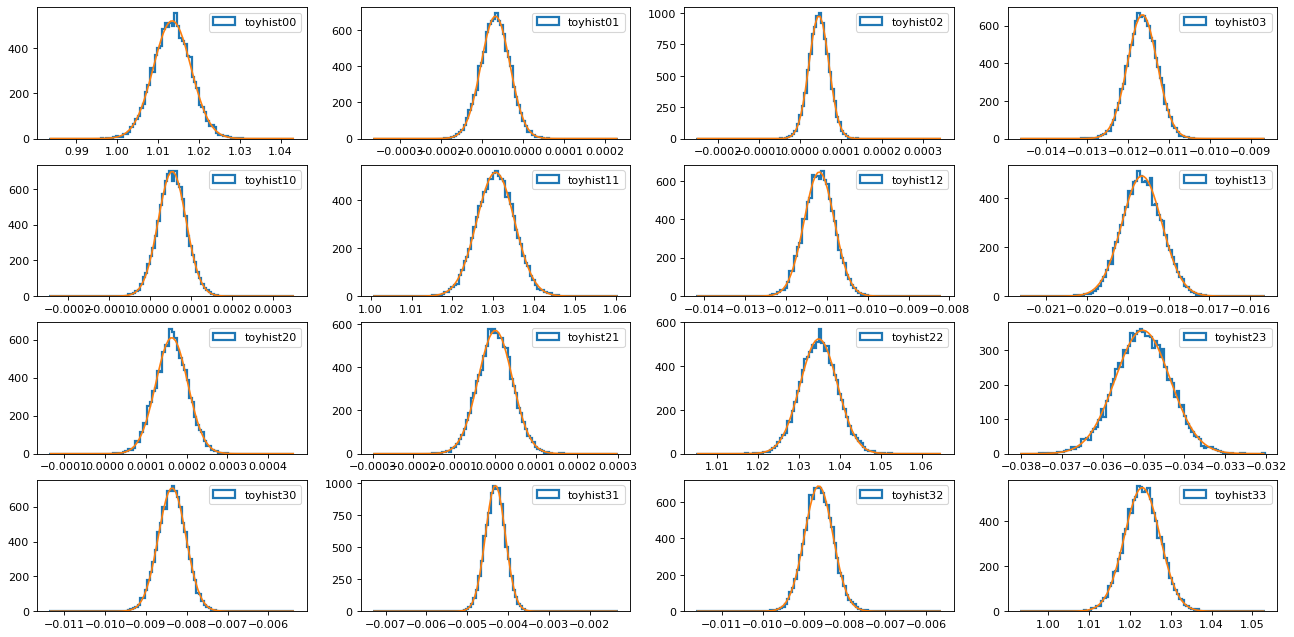

In [25]:
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))


fig = plt.figure(figsize=(20, 10),dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4,4,1)
ax01 = plt.subplot(4,4,2)
ax02 = plt.subplot(4,4,3)
ax03 = plt.subplot(4,4,4)

ax10 = plt.subplot(4,4,5)
ax11 = plt.subplot(4,4,6)
ax12 = plt.subplot(4,4,7)
ax13 = plt.subplot(4,4,8)

ax20 = plt.subplot(4,4,9)
ax21 = plt.subplot(4,4,10)
ax22 = plt.subplot(4,4,11)
ax23 = plt.subplot(4,4,12)

ax30 = plt.subplot(4,4,13)
ax31 = plt.subplot(4,4,14)
ax32 = plt.subplot(4,4,15)
ax33 = plt.subplot(4,4,16)

axes = [[ax00,ax01,ax02,ax03],
        [ax10,ax11,ax12,ax13],
        [ax20,ax21,ax22,ax23],
        [ax30,ax31,ax32,ax33]]
dx=0.03
dx1=0.003
dx2=0.0003
## IMPORTANT! Find suitable ranges to fit/plot gaussian distributions successfully!
ranges = [[(matrix_inv[0][0]-dx,matrix_inv[0][0]+dx),(matrix_inv[0][1]-dx2,matrix_inv[0][1]+dx2), (matrix_inv[0][2]-dx2,matrix_inv[0][2]+dx2), (matrix_inv[0][3]-dx1,matrix_inv[0][3]+dx1)],
          [(matrix_inv[1][0]-dx2,matrix_inv[1][0]+dx2),(matrix_inv[1][1]-dx,matrix_inv[1][1]+dx), (matrix_inv[1][2]-dx1,matrix_inv[1][2]+dx1), (matrix_inv[1][3]-dx1,matrix_inv[1][3]+dx1)],
          [(matrix_inv[2][0]-dx2,matrix_inv[2][0]+dx2),(matrix_inv[2][1]-dx2,matrix_inv[2][1]+dx2), (matrix_inv[2][2]-dx,matrix_inv[2][2]+dx), (matrix_inv[2][3]-dx1,matrix_inv[2][3]+dx1)],
          [(matrix_inv[3][0]-dx1,matrix_inv[3][0]+dx1),(matrix_inv[3][1]-dx1,matrix_inv[3][1]+dx1), (matrix_inv[3][2]-dx1,matrix_inv[3][2]+dx1), (matrix_inv[3][3]-dx,matrix_inv[3][3]+dx)]]


# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:],bins=100,range=ranges[j][k],  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        axes[j][k].legend()

        ## Guess initial parameters of the fit by taking random value from hist and std
        _p0 = [ntoy/10.,np.std(inverse_toys[j,k,:]),np.std(inverse_toys[j,k,:])]
        if j==k:
            sig=dx
        else:
            sig=dx2
            
        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, p0=[600,matrix_inv[j][k],sig], maxfev=100000)
        h_fit = gauss(h_mid, *coeffs)
        
        axes[j][k].plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")


## Getting the individual cross sections

First try: fit a breit wigner + x^2, didnt work, to few points and complicated equation. Then: Whats the closest energy? Take over this luminosity.

In [26]:
lumi_liste = []
energy_list = []
for element in data_elep*2:
    dist = np.abs(lumi_matrix[:,0] - element)
    #print(dist,element)
    indices = [i for i, x in enumerate(dist) if x == min(dist)]
    lumi_liste.append(lumi_matrix[indices[0],1])
    energy_list.append(lumi_matrix[indices[0],0])

In [27]:
qq_events = np.array([0,0,0,0,0,0,0])
ee_events = np.array([0,0,0,0,0,0,0])
mm_events = np.array([0,0,0,0,0,0,0])
tt_events = np.array([0,0,0,0,0,0,0])


for number in range(0,len(ID_array)):
    if ID_array[number] == 1:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        qq_events[index[0]] += 1
    elif ID_array[number] == 2:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        ee_events[index[0]] += 1
    elif ID_array[number] == 3:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        mm_events[index[0]] += 1
    elif ID_array[number] == 4:
        #print(lumi_liste[number])
        index = [i for i in range(len(lumi_matrix[:,1])) if lumi_matrix[i,1] == lumi_liste[number]]
        tt_events[index[0]] += 1
        

print("qq",qq_events)
print("ee",ee_events)
print("mm",mm_events)
print("tt",tt_events)

qq [ 3521  5315  7518 92445 15249  6619  7399]
ee [ 2177  1877  1464 11929  1970  1225  1865]
mm [ 190  297  375 4452  771  320  376]
tt [ 287  349  401 5357  904  416  459]


In [28]:
qq_cross = qq_events / lumi_matrix[:,1]
ee_cross = ee_events / lumi_matrix[:,1]
mm_cross = mm_events / lumi_matrix[:,1]
tt_cross = tt_events / lumi_matrix[:,1]
tot_cross = qq_cross +ee_cross +mm_cross +tt_cross

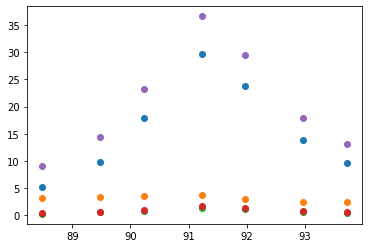

In [29]:
plt.plot(lumi_matrix[:,0],qq_cross,ls="",marker="o")
plt.plot(lumi_matrix[:,0],ee_cross,ls="",marker="o")
plt.plot(lumi_matrix[:,0],mm_cross,ls="",marker="o")
plt.plot(lumi_matrix[:,0],tt_cross,ls="",marker="o")
plt.plot(lumi_matrix[:,0],tot_cross,ls="",marker="o")